In [1]:
import os
import pickle

import numpy as np
import matplotlib as mpl
mpl.use('pgf')
import matplotlib.pyplot as plt
import scipy as sp
from scipy import interpolate

import pandas as pd
from root_pandas import read_root
from uncertainties import ufloat

import ROOT
from ROOT import gSystem

/opt/miniconda/envs/root_ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
gSystem.Load('libRooFit')

0

In [3]:
gSystem.Load('./RooFitSources/build/libAcceptances.so')

0

In [4]:
from ROOT import (RooCubicSplineFun,
                  RooAbsReal,
                  RooArgList,
                  std,
                  RooRealVar,
                 )

In [5]:
# Magics first (server issues)
%matplotlib inline 
# Do below if you want interactive matplotlib plot ()
# %matplotlib notebook 
# https://ipython.org/ipython-doc/dev/config/extensions/autoreload.html
%reload_ext autoreload
%autoreload 1
# https://github.com/jrjohansson/version_information
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pandas, 

Software versions
Python 3.6.4 64bit [GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
IPython 6.4.0
OS Linux 3.10.0 862.9.1.el7.x86_64 x86_64 with centos 7.5.1804 Core
numpy 1.15.0
scipy 1.1.0
matplotlib 2.2.2
pandas 0.23.4
Fri Aug 24 12:18:56 2018 CEST

In [6]:
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
}
mpl.rcParams.update(pgf_with_rc_fonts)

# plt.rcParams['figure.figsize'] = (14, 10)
# plt.rcParams['font.size'] = 16

In [7]:
# parameters obtained from the different decay-time fits
# from /afs/cern.ch/work/a/adudziak/public/workspace/DsK3fbPAPER/Bs2DsPi_sFit/nominal_resolution/
npKnots = np.array([0.50, 1.0,  1.5, 2.0, 3.0, 12.0])
MCKdivMCPitimesDataPi = np.array([0.3664407781, 0.566982983334, 0.779405394092,
                                  0.966060333357, 1.0695450788, 1.15319484969])
DataPi = np.array([0.390195, 0.595695, 0.789784,
                   1.014400, 1.099279, 1.188763])
MCPi = np.array([0.475472, 0.678918, 0.934934,
                 1.095435, 1.194616, 1.262790])
MCK = np.array([0.446525, 0.646195, 0.922648,
                1.043234, 1.162303, 1.225006])

In [8]:
# transform knots into something ROOT can use
rKnots = std.vector("double")(6)
for i, v in enumerate(npKnots):
    rKnots[i] = v
    print(rKnots[i])

0.5
1.0
1.5
2.0
3.0
12.0


In [9]:
# define the time variable as RooRealVar
# the time range is the same as for the DsK configurations
time = RooRealVar('time', 'time', 0.4, 15)
tMax = time.getMax()  # as in the fitting script

In [10]:
def argListFromArray(arr, var_prefix='coeff'):
    argList = RooArgList()
    handles = []
    for i, c in enumerate(arr):
        varName = f'{var_prefix}{len(handles)}'
        handles.append(RooRealVar(varName, varName, c))
        argList.add(handles[-1])
    return argList, handles

### Coefficient calculation

as described in the ANA note, the last coefficient $c_n$ is calculated
in an iterative way:

$$
c_n = c_{n-1}
    + \frac{c_{n-2} - c_{n-1}}{t_{n-2} - t_{n-1}}
    (t_n - t_{n-1})
$$

but this method is indeed implemented like

$$
c_n = c_{n-1}
    + \frac{c_{n-2} - c_{n-1}}{t_{n-2} - t_{n-1}}
    (t_\mathrm{max} - t_{n-1})
$$

Otherwise, the term $(t_n - t_{n-1})$ would be zero in the case of "double knots" which would lead to $c_n = 0$.

In [11]:
def prepareCoeffs(coeffs, coeffHandles, knots, var_prefix='coeff'):
    varName = f'{var_prefix}{len(coeffHandles)}'
    coeffHandles.append(RooRealVar(varName, varName, 1))
    coeffs.add(coeffHandles[-1])

    sizeKnots = len(knots)
    sizeCoeffs = len(coeffs)
    c1 = (tMax - knots[sizeKnots-1]) / (knots[sizeKnots-2] - knots[sizeKnots-1])
    c2 = 1 - c1
    coeff8 = c1 * coeffs[sizeCoeffs-2].getVal() + c2 * coeffs[sizeCoeffs-1].getVal()

    varName = f'{var_prefix}{len(coeffHandles)}'
    coeffHandles.append(RooRealVar(varName, varName, coeff8))
    coeffs.add(coeffHandles[-1])
    
    return coeffs, coeffHandles, knots

In [12]:
def translateParams(npCoeffs, npKnots):
    coeffs, coeffHandles = argListFromArray(npCoeffs)
    coeffs, coeffHandles, knots = prepareCoeffs(coeffs, coeffHandles, npKnots)
    # transform knots into something ROOT can use
    rKnots = std.vector("double")(len(knots))
    for i, v in enumerate(knots):
        rKnots[i] = v
    return coeffs, coeffHandles, rKnots

In [13]:
analyticalCoeffs, analyticalHandles, analyticalKnots = translateParams(MCKdivMCPitimesDataPi, npKnots)
analyticalRooSpline = RooCubicSplineFun('analytical', 'analytical', time, analyticalKnots, analyticalCoeffs)

DataPiCoeffs, DataPiHandles, DataPiKnots = translateParams(DataPi, npKnots)
DataPiRooSpline = RooCubicSplineFun('dataPi', 'dataPi', time, DataPiKnots, DataPiCoeffs)

MCPiCoeffs, MCPiHandles, MCPiKnots = translateParams(MCPi, npKnots)
MCPiRooSpline = RooCubicSplineFun('MCPi', 'MCPi', time, MCPiKnots, MCPiCoeffs)

MCKCoeffs, MCKHandles, MCKKnots = translateParams(MCK, npKnots)
MCKRooSpline = RooCubicSplineFun('MCK', 'MCK', time, MCKKnots, MCKCoeffs)

In [14]:
xs = np.linspace(time.getMin(), time.getMax(), 1000)

In [15]:
analyticalYs, DataPiYs, MCPiYs, MCKYs = [], [], [], []
for x in xs:
    time.setVal(x)
    analyticalYs.append(analyticalRooSpline.getVal())
    DataPiYs.append(DataPiRooSpline.getVal())
    MCPiYs.append(MCPiRooSpline.getVal())
    MCKYs.append(MCKRooSpline.getVal())
analyticalYs = np.asarray(analyticalYs)
DataPiYs = np.asarray(DataPiYs)
MCPiYs = np.asarray(MCPiYs)
MCKYs = np.asarray(MCKYs)

In [16]:
numericYs = DataPiYs * MCKYs / MCPiYs

In [17]:
[analyticalKnots[0]] + [analyticalKnots[i] for i in range(len(analyticalKnots))] + [analyticalKnots[len(analyticalKnots) - 1]]

[0.5, 0.5, 1.0, 1.5, 2.0, 3.0, 12.0, 12.0]

In [18]:
[analyticalCoeffs[i].getVal() for i in range(len(analyticalCoeffs))]

[0.3664407781,
 0.566982983334,
 0.779405394092,
 0.966060333357,
 1.0695450788,
 1.15319484969,
 1.0,
 0.9489350501033333]

/net/nfshome/home/kheinicke/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


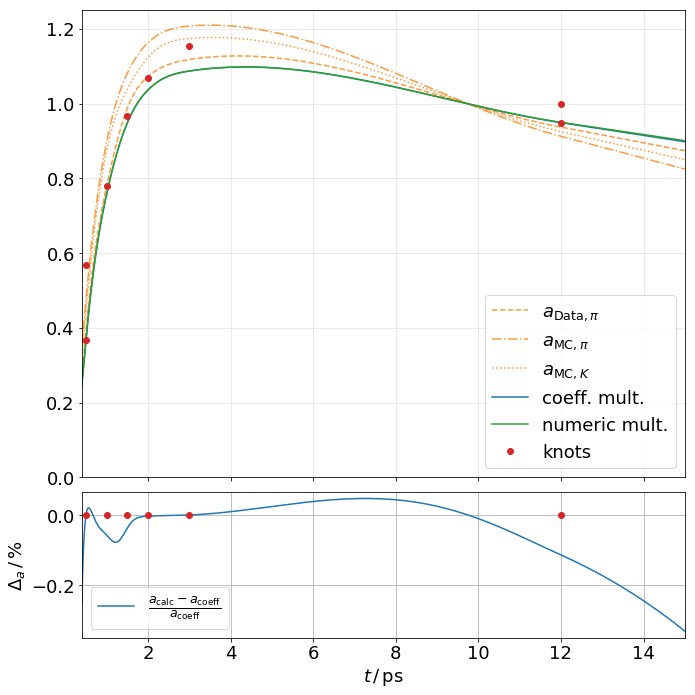

In [19]:
plt.rc('font', size=18)
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)

plt.plot(xs, DataPiYs, 'C1--', alpha=0.8, label=r'$a_{\mathrm{Data},\pi}$')
plt.plot(xs, MCPiYs, 'C1-.', alpha=0.8, label=r'$a_{\mathrm{MC},\pi}$')
plt.plot(xs, MCKYs, 'C1:', alpha=0.8, label=r'$a_{\mathrm{MC},K}$')
plt.plot(xs, analyticalYs, 'C0', label='coeff. mult.')
plt.plot(xs, numericYs, 'C2', label='numeric mult.')
plt.xlim(0.4, 15)
plt.ylim(0, 1.25)
plt.plot(
    [analyticalKnots[0]] + [analyticalKnots[i] for i in range(len(analyticalKnots))] + [analyticalKnots[len(analyticalKnots) - 1]],
    [analyticalCoeffs[i].getVal() for i in range(len(analyticalCoeffs))],
    'C3o', label='knots')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)
plt.plot(xs, 100 * (analyticalYs - numericYs) / analyticalYs, label=r'$\frac{a_\mathrm{calc} - a_\mathrm{coeff}}{a_\mathrm{coeff}}$')
plt.plot(npKnots, np.zeros_like(npKnots), 'C3o')
plt.legend(loc='best')
plt.grid()
plt.ylabel(r'$\Delta_a\,/\,\%$')
plt.xlabel(r'$t\,/\,\mathrm{ps}$')
plt.tight_layout()
plt.xlim(0.4, 15)
plt.gcf().subplots_adjust(hspace=0.1)
plt.savefig(os.path.expanduser('~/Roospline-plot.pdf'))
plt.show()

# The same function, using scipy BSplines

In [20]:
bKnots = np.concatenate((4 * [npKnots[0]], npKnots[1:-1], 4 * [npKnots[-1]]))

In [21]:
spline = interpolate.BSpline(bKnots, [analyticalCoeffs[i].getVal() for i in range(len(analyticalCoeffs))], k=3,
                             extrapolate=True)

In [22]:
xs_middle = np.linspace(npKnots[0], npKnots[-1], 400)
xs_left = np.linspace(0, npKnots.min(), 20)
xs_right = np.linspace(npKnots.max(), time.getMax(), 20)

In [23]:
ys_left = spline.derivative(nu=1)(npKnots[0]) * xs_left
ys_right = spline.derivative(nu=1)(npKnots[-1]) * xs_right

In [24]:
offset_left = (spline.derivative()(npKnots[0]) * npKnots[0] - spline(npKnots[0]))
offset_right = (spline.derivative()(npKnots[-1]) * npKnots[-1] - spline(npKnots[-1]))

/net/nfshome/home/kheinicke/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


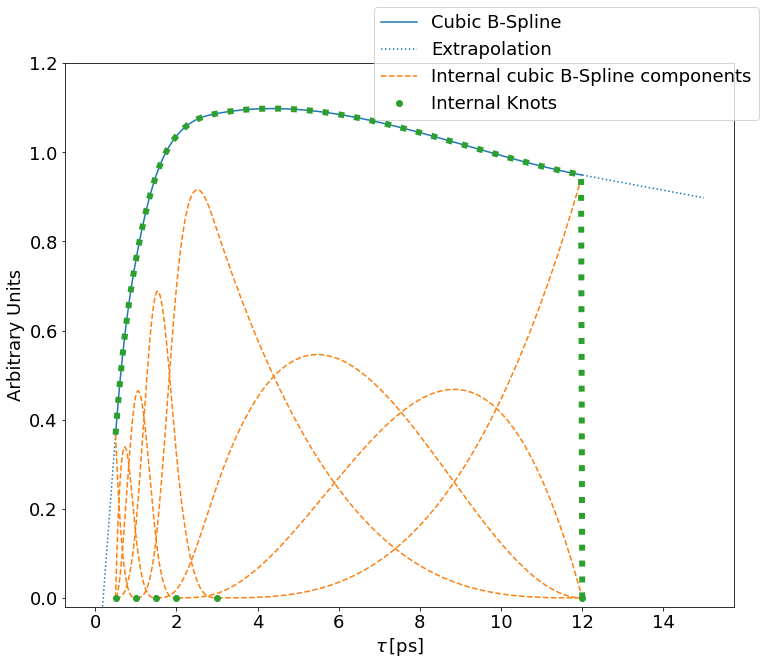

In [37]:
plt.figure(figsize=(12, 10))
plt.plot(xs_middle, spline(xs_middle), label='Cubic B-Spline')
plt.plot(xs_left, ys_left - offset_left, 'C0:', label='Extrapolation')
plt.plot(xs_right, ys_right - offset_right, 'C0:')
ys_sum = np.zeros_like(xs_middle)

# Plot the B-Spline components
for i in range(len(analyticalCoeffs)):
    ys = analyticalCoeffs[i].getVal() * spline.basis_element(bKnots[i:i+5], extrapolate=False)(xs_middle)
    plt.plot(xs_middle[:-1], ys[:-1], 'C1--', label=('Internal cubic B-Spline components' if i == 0 else None))
    ys[np.isnan(ys)] = 0
    ys_sum += ys

# plot the internal knots
plt.plot(npKnots, np.zeros_like(npKnots), 'C2o', label='Internal Knots')
plt.plot(xs_middle, ys_sum, 'C2:', lw=6)  # this should exactly match the bspline
plt.ylim(-0.02, 1.2)
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1.12))
plt.xlabel(r'$\tau\,[\mathrm{ps}]$')
plt.ylabel('Arbitrary Units')
plt.savefig(os.path.expanduser('~/Roospline-plot.pdf'))
pickle.dump(plt.gcf(), open(os.path.expanduser('~/Roospline-plot.pcl'), 'wb'))
plt.show()

In [26]:
components = {}
for i, coeff in enumerate(MCKdivMCPitimesDataPi):
    npCoeffs_ = np.zeros_like(MCKdivMCPitimesDataPi)
    npCoeffs_[i] = coeff

    analyticalCoeffs_, analyticalHandles_, analyticalKnots_ = translateParams(npCoeffs_, npKnots)
    analyticalRooSpline_ = RooCubicSplineFun('analytical', 'analytical', time, analyticalKnots_, analyticalCoeffs_)

    analyticalYs_ = []
    for x in xs:
        time.setVal(x)
        analyticalYs_.append(analyticalRooSpline_.getVal())
    components[i] = np.array(analyticalYs_)

/net/nfshome/home/kheinicke/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


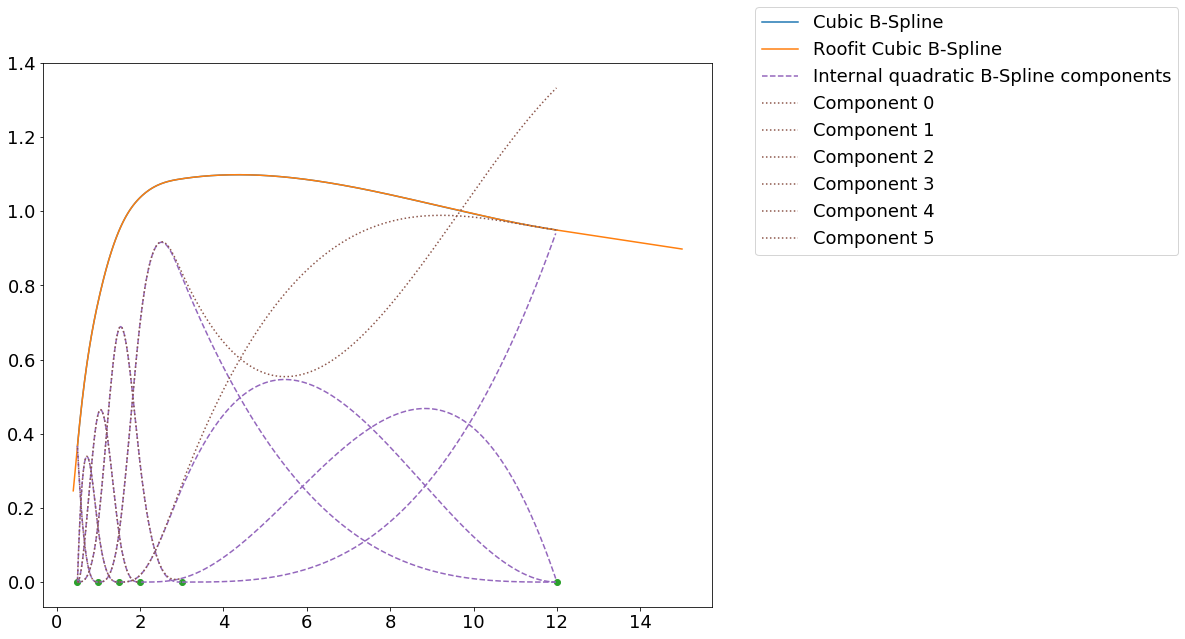

In [27]:
plt.figure(figsize=(12, 10))
plt.plot(xs_middle, spline(xs_middle), label='Cubic B-Spline')
plt.plot(xs, analyticalYs, label='Roofit Cubic B-Spline')
plt.plot(npKnots, np.zeros_like(npKnots), 'o')

# Plot the B-Spline components
for i in range(len(analyticalCoeffs)):
    ys = analyticalCoeffs[i].getVal() * spline.basis_element(bKnots[i:i+5], extrapolate=False)(xs_middle)
    plt.plot(xs_middle[:-1], ys[:-1], 'C4--', label=('Internal quadratic B-Spline components' if i == 0 else None))
    
for i, component in list(components.items()):
    sel = (xs >= bKnots[i:i+5].min()) & (xs < bKnots[i:i+5].max())
    # print(xs[sel].min(), xs[sel].max())
    plt.plot(xs[sel], component[sel], 'C5:', label=f'Component {i}')

plt.legend(loc='best', bbox_to_anchor=(1.05, 1.12))
plt.show()

In [28]:
bKnots.shape

(12,)